In [48]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd
import configs

device = 'cpu'

In [49]:
def format_model_name(key):
    if key == 'RNN-S' or key == 'FF-TD':
        return key
    else:
        return 'Invalid'

In [50]:
def get_sparsity(key):
    p = re.compile('.*sparsity(.+?)\/.*')
    if 'sparsity' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

def get_sigma(key):
    p = re.compile('.*sigma(.+?)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

In [51]:
hue_order = ['RNN-S', 'FF-TD']

# Load TD results

In [52]:
with open(f"{configs.engram_dir}03_hannah_dset/td_results.p", 'rb') as f:
    td_results = pickle.load(f)

In [53]:
td_results['init_sparsities'] = np.array(td_results['init_sparsities']).astype(float)
td_results['final_sparsities'] = np.array(td_results['final_sparsities']).astype(float)
td_results['final_sparsities'] = np.around(td_results['final_sparsities'], decimals=2)
td_results['sigmas'] = np.array(td_results['sigmas']).astype(float)
td_results['gammas'] = np.array(td_results['gammas']).astype(float)
td_results['models'] = np.array([format_model_name(m) for m in td_results['models']])
td_results['losses'] = np.array(td_results['final_losses']).astype(float)

In [54]:
td_df = pd.DataFrame({
    'Sparsity': td_results['final_sparsities'],
    'Sigma': td_results['sigmas'],
    'Gamma': td_results['gammas'],
    'Model': td_results['models'],
    'TD Loss': td_results['losses']
    })
td_df = td_df[td_df['Sparsity'] <= 0.2]

# Make gradient plots

In [55]:
_gamma = 0.75

In [56]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

In [57]:
def get_edge_nans(im):
    """ im is processed row-by-row (e.g., sigma by sparsity) """
    
    mask = np.zeros(im.shape).astype(bool)
    nrows, ncols = im.shape
    for i in range(nrows):
        j = 0
        while np.isnan(im[i,j]) and (j < ncols):
            mask[i,j] = True
            j += 1
    return mask

In [58]:
plt.rcParams.update({'hatch.color': 'darkgray'})

In [59]:
td_df['Gamma'].to_numpy()

array([0.8 , 0.8 , 0.8 , ..., 0.75, 0.75, 0.75])

In [68]:
def make_gradients(
    x_key, y_key, z_key, td_df,
    chance_key=None, chance_df=None,
    cmap="Reds", title=None,
    figname=None, figsize=[6.4, 4.8],
    xlabel=None, ylabel=None,
    interpolate=False, smooth=False,
    leave_edge_nans=True, xlim=None,
    cbar_ticks=None, cbar_tick_labels=None,
    vmin=None, vmax=None
    ):
    
    # Load in data
    xs = td_df[x_key].to_numpy()
    ys = td_df[y_key].to_numpy()
    zs = td_df[z_key].to_numpy()
    
    # Collect data into a meshgrid
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dxs = np.around(x_list[1:] - x_list[:-1], decimals=2)
    dys = np.around(y_list[1:] - y_list[:-1], decimals=2)
    if np.unique(dxs).size > 1 or np.unique(dys).size > 1:
        if smooth:
            print("Warning: Smoothing with inconsistent dx/dy")
    x_list = np.concatenate((x_list, [x_list[-1]+dxs[-1]]))
    y_list = np.concatenate((y_list, [y_list[-1]+dys[-1]]))
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            ij_idx = np.logical_and(xs==x[i,j], ys==y[i,j])
            _val = np.nanmean(zs[ij_idx])
            if chance_df is not None:
                chance_ij_idx = np.logical_and(
                    chance_df[x_key]==x[i,j],
                    chance_df[y_key]==y[i,j]
                    )
                _chance_val = np.nanmean(
                    chance_df[chance_key][chance_ij_idx].to_numpy()
                    )
                val = _chance_val/_val
            else:
                val = _val
            z[i,j] = val
    
    # Plot raw grid values
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('yellow')
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(
        x, y, z, cmap=cmap
        )
    fig.colorbar(im, ax=ax)
    plt.show()
    
    # Remove padding used for pcolormesh plot
    x = x[:-1,:-1]
    y = y[:-1,:-1]
    z = z[:-1,:-1]

    # Mark NaNs
    nan_mask = np.isnan(z)
    edge_nan_mask = get_edge_nans(z)

    # Interpolate to fill in NaN cells
    if interpolate:
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals

    # Smooth over cells to denoise
    if smooth:
        from astropy.convolution import Gaussian2DKernel
        from astropy.convolution import convolve
        kernel = Gaussian2DKernel(x_stddev=1, y_stddev=1)
        z = convolve(z, kernel, preserve_nan=True)
    
    # Generate contour plots
    if vmin is not None and vmax is not None:
        z = np.clip(z, vmin, vmax)
    if vmin is not None and vmax is not None:
        levels = MaxNLocator(nbins=20).tick_values(vmin, vmax)
    else:
        levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x, y, z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
    if leave_edge_nans: # White out parts that were extrapolated
        nans = np.argwhere(edge_nan_mask)
        nan1 = nans[0]; nan2 = nans[-1]
        nan1x = x[nan1[0],nan1[1]]
        nan1y = y[nan1[0],nan1[1]]
        nan2x = x[nan2[0],nan2[1]]
        nan2y = y[nan2[0],nan2[1]]
        max_y = y.max()
        plt.fill(
            [nan1x, nan2x, nan1x],
            [nan1y, nan2y, max_y],
            color='white'
            )
    if xlim is not None: # Adjust x limits
        plt.xlim(xlim)
       
    cbar = fig.colorbar(cf, ax=ax, ticks=cbar_ticks)
    if cbar_ticks is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.yticks([0,1,2,3])
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300, transparent=True)
    plt.show()
    
    return x, y, z

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:33: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


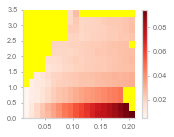

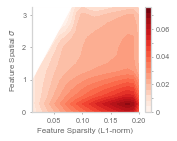

In [69]:
# RNN
_x, _y, _z = make_gradients(
    'Sparsity', 'Sigma', 'TD Loss',
    td_df[(td_df['Model']=='RNN-S')&(td_df['Gamma']==_gamma)],
    title='',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'../figures/5d',
    interpolate=True, smooth=True, figsize=[2.5,2],
    xlim=[td_results['final_sparsities'].min(), 0.2],
    cbar_ticks=np.arange(0, 0.08, 0.01),
    cbar_tick_labels=[0, '', 0.02, '', 0.04, '', 0.06, ''],
    vmax=0.076, vmin=0
    )

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:33: RuntimeWarning: Mean of empty slice
  _val = np.nanmean(zs[ij_idx])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('yellow')
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_18690/2945168922.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


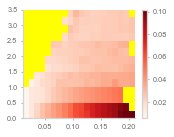

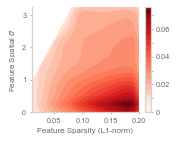

In [70]:
# Linear
_x, _y, _z = make_gradients(
    'Sparsity', 'Sigma', 'TD Loss',
    td_df[(td_df['Model']=='FF-TD')&(td_df['Gamma']==_gamma)],
    title='',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'../figures/5e',
    interpolate=True, smooth=True, figsize=[2.5,2],
    xlim=[td_results['final_sparsities'].min(), 0.2],
    cbar_ticks=np.arange(0, 0.08, 0.01),
    cbar_tick_labels=[0, '', 0.02, '', 0.04, '', 0.06, ''],
    vmax=0.076, vmin=0
    )